In [ ]:
!pip install pydub tensorflow_io

In [ ]:
import tensorflow_datasets as tfds

(dataset_train_original, dataset_validate_original), info = tfds.load(
    "spoken_digit",
    split=['train[:80%]','train[80%:]'],
    as_supervised=True, #data not in dictionary
    with_info=True
)
info

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir='/root/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
  

tf.Tensor([   0    0 -256 ... -512 -256 -512], shape=(1525,), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


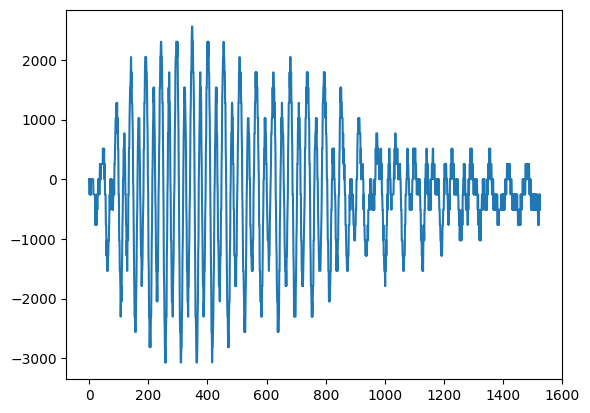

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import librosa
import numpy as np

for audio, label in dataset_train_original.take(1):
  print(audio) # shape=1525 bei Sampling of 8kHz = 1/5 of a second length
  print(label)
  plt.plot(audio)

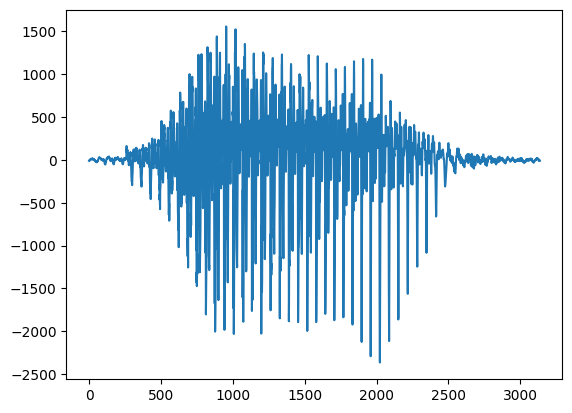

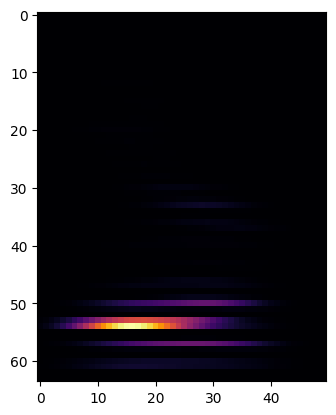

In [ ]:
for audio, label in dataset_train_original.shuffle(2500).take(1):
  audio = audio.numpy().astype('float32') # converting to numpy.

  # Plotting shape
  plt.plot(audio)
  plt.show()
  # listen to it
  display(Audio(audio, rate=8000))

  # Feature extraction
  mel = librosa.feature.melspectrogram(
      y=audio, sr=8000, n_mels=64, hop_length=64 # hop_length=moving window size. n_mels=bins
  )
  mel = mel[::-1,:]
  mel /= np.max(mel) # normalize
  plt.imshow(mel, cmap='inferno')

tf.Tensor(2, shape=(), dtype=int64)


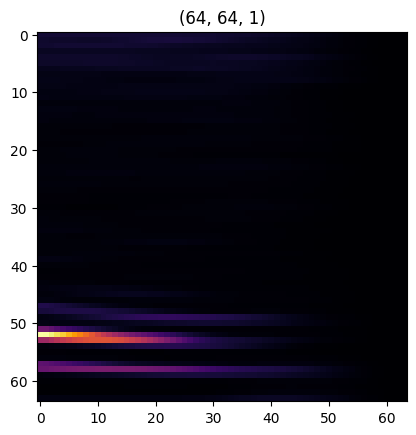

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio

def preprocess(audio, label):
  # TODO Go mel spectrogram
  # TODO ensure same shape

  audio = tf.cast(audio, dtype=tf.float32) / 32768.0 # casting to float32 and normalizing (32768 is highest number in set)

  spectrogram = tfio.audio.spectrogram(
      audio, nfft=1024, window=1024, stride=64
  )

  spectrogram = tfio.audio.melscale(
      spectrogram, rate=8000, mels=64, fmin=0, fmax=4000
  ) # turn spectrogram into mel
  spectrogram /= tf.math.reduce_max(spectrogram) # normalize!

  # adjust spectrograms so that they all have the same size
  spectrogram = tf.expand_dims(spectrogram, axis=-1) # additional dimension, so that image has 3 dimensions --> Conv2D can be used
  spectrogram = tf.image.resize(spectrogram, (64, 64)) # resizing the image
  #spectrogram = tf.image.resize_with_pad( # padding
  #    spectrogram,
  #    target_height=64,
  #    target_width=64
  #)

  # x should be time (not necessary für ANN!)
  spectrogram = tf.transpose(spectrogram, perm=(1, 0, 2)) # flipping axis
  spectrogram = spectrogram[::-1, :, :] # turn it around

  return spectrogram, label

dataset = dataset_train_original.map(lambda audio, label: preprocess(audio, label))

for spectrogram, label in dataset.take(1):
  plt.imshow(spectrogram, cmap='inferno')
  plt.title(spectrogram.shape)
  print(label)

In [ ]:
dataset_train = dataset_train_original.map(lambda audio, label: preprocess(audio, label))
dataset_train = dataset_train.cache().shuffle(2500).batch(32)

dataset_validate = dataset_validate_original.map(lambda audio, label: preprocess(audio, label))
dataset_validate = dataset_validate.cache().batch(32)

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(
    4, (3, 3), padding='same', activation='relu',
    input_shape=(64,64, 1)
))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_validate
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 4)         40        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 4)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 4)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 8)        

In [ ]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()

def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

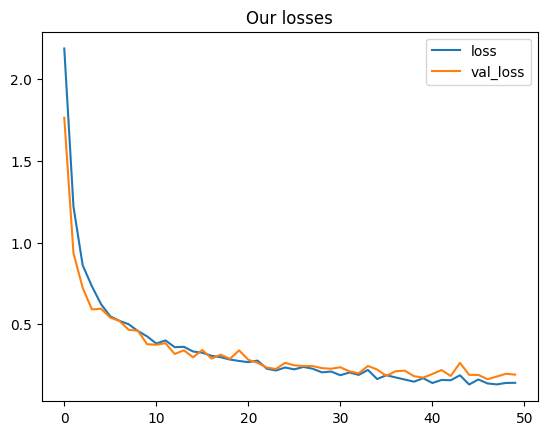

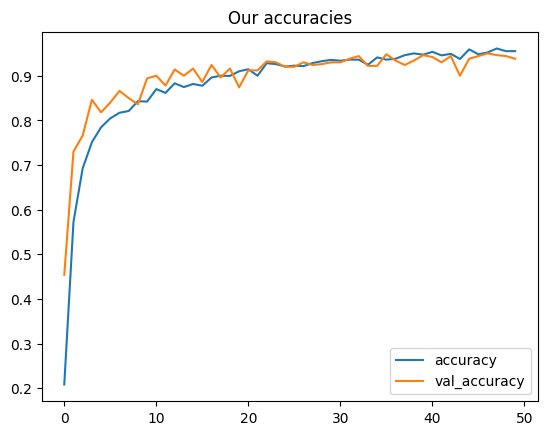

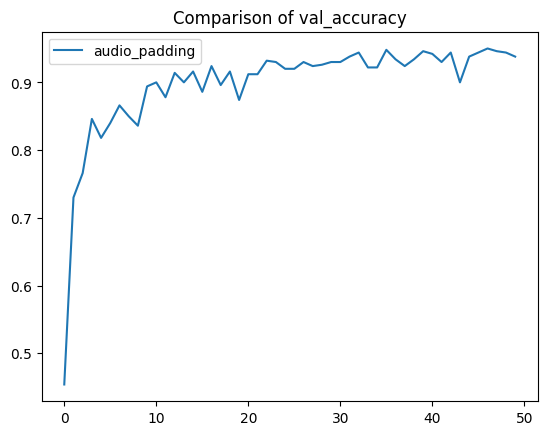

In [ ]:
history_list = {}
history_list['audio_padding'] = history.history
render_history(history.history)
compare_histories()

In [ ]:
model = models.Sequential()
model.add(layers.Reshape((64, 64), input_shape=(64, 64, 1)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 64, 64)            0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(64, 64, 1)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.40))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(10, activation='softmax'))



model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_validate
)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 4096)              0         
                                                                 
 dense_69 (Dense)            (None, 128)               524416    
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dropout_44 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 64)                4160      
                                                                 
 dropout_45 (Dropout)        (None, 64)              

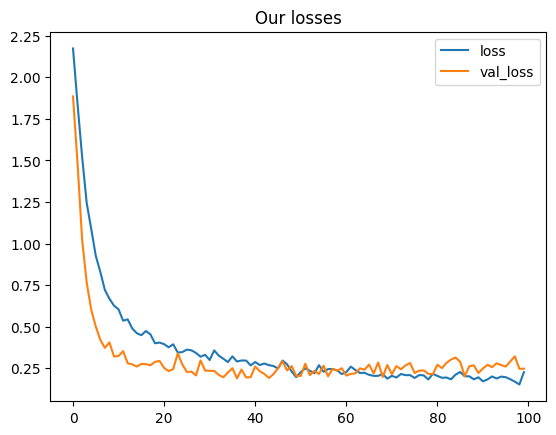

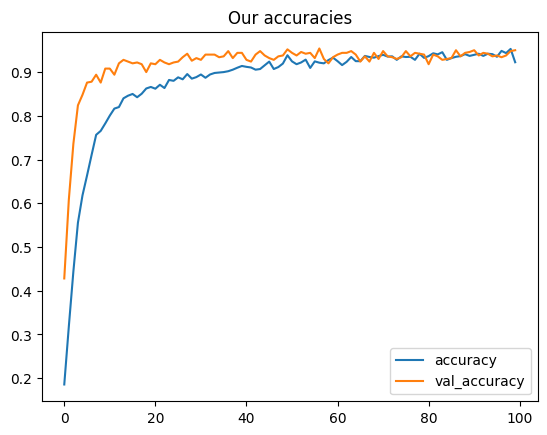

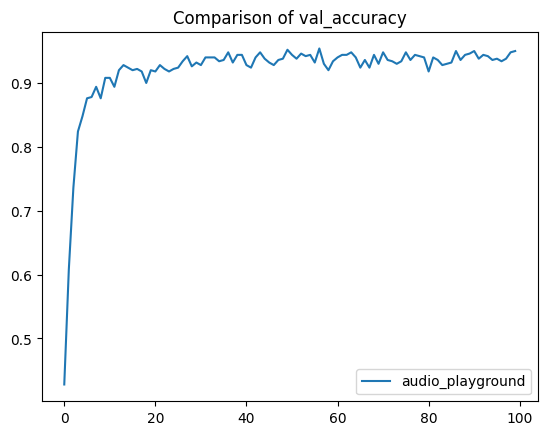

In [ ]:
history_list = {}
history_list['audio_playground'] = history.history
render_history(history.history)
compare_histories()